<a href="https://colab.research.google.com/github/JunHyeok-Navy/Machine_Learning/blob/main/Resnet_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet from Scratch with Pytorch 

## Contents

1. What is ResNet?
2. ResNet Implementation
3. Evaluate the Implementation
4. Transfer Learning?
5. Data EDA
6. Data Loader & Augmentation
7. Modeling & Comparion between unpretrained and pretrained
8. Inference & Submit

# What is ResNet?

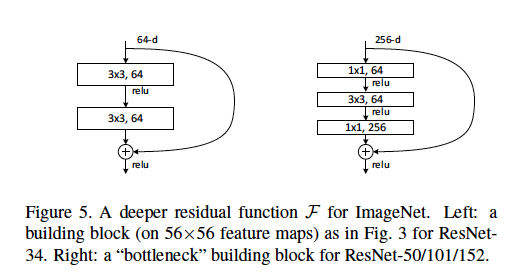

### ResNet is a Network made by CNN & Residual Connection
### Back to 2015, ResNet made a groundbreaking improvement in ImageNet Competition
### Its complexity and parameters are muck less than VGG model
### However, its depth and width of representation are much more depper

# ResNet Implementation from Scratch

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary

In [2]:
class ConvBlock(nn.Module):
  '''
  Residual Block.

  Parameters
  ----------
  model_name : str
  Select the architecture of model. (e.g ResNet-18 or ResNet-152)

  in_chan : int
  Channel of input tensor.

  out_chan : int
  Channel of output tensor.

  stride : int
  Stride parameter of Conv2d layer.

  is_bottleneck : bool
  Type of model for splitting forward function.

  Attributes
  ----------
  self.conv, self.bn, self.relu : nn.Conv2d, nn.BatchNorm2d, nn.ReLU
  There are 2 or 3 computational layers by model type.

  self.downsample : nn.Conv2d
  Downsampling funciton. (Projection)
  '''

  def __init__(self, model_name, in_chan, out_chan, stride, is_downsample=True):
    super(ConvBlock, self).__init__()
    self.is_downsample = is_downsample

    if model_name in ['ResNet-18', 'ResNet-34']:
      self.is_bottleneck = False
      self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=3, stride=stride, padding=1)
      self.bn1 = nn.BatchNorm2d(out_chan)
      self.relu1 = nn.ReLU()
      self.conv2 = nn.Conv2d(out_chan, out_chan, kernel_size=3, stride=1, padding=1)
      self.bn2 = nn.BatchNorm2d(out_chan)
      self.relu2 = nn.ReLU()

      if stride != 1 or is_downsample: # For making output of plain network output channel and identity channel
        self.downsample = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_chan)
        )
    
    elif model_name in ['ResNet-50', 'ResNet-101', 'ResNet-152']:
      self.is_bottleneck = True
      self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=1, stride=stride, padding=0)
      self.bn1 = nn.BatchNorm2d(out_chan)
      self.relu1 = nn.ReLU()
      self.conv2 = nn.Conv2d(out_chan, out_chan, kernel_size=3, stride=1, padding=1)
      self.bn2 = nn.BatchNorm2d(out_chan)
      self.relu2 = nn.ReLU()
      self.conv3 = nn.Conv2d(out_chan, out_chan*4, kernel_size=1, stride=1, padding=0)
      self.bn3 = nn.BatchNorm2d(out_chan*4)
      self.relu3 = nn.ReLU()

      if stride != 1 or is_downsample:
        self.downsample = nn.Sequential(
            nn.Conv2d(in_chan, out_chan*4, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_chan*4)
        )

    else:
      raise ValueError(' "model_name" must be ResNet-18, ResNet-34, ResNet-50, ResNet-101, or ResNet-152')

  def forward(self, x):
    '''
    Forward Propagation.

    Parameters
    ----------
    x : torch.Tensor
    Shape : (n_samples, in_chan, img_size, img_size)

    Attributes
    ----------
    num_layers : int
    The number of layers.
    If "model_name" is "ResNet-18" or "ResNet-34", "num_layers" is 2. Else, 3.

    identity : torch.Tensor
    At last of the block, identity is added with final output.
    '''

    if self.is_bottleneck:
      identity = x
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu1(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu2(x)
      x = self.conv3(x)
      x = self.bn3(x)
      if self.is_downsample:
        identity = self.downsample(identity)
      x += identity
      x = self.relu3(x)

    else:
      identity = x
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu1(x)
      x = self.conv2(x)
      x = self.bn2(x)
      if self.is_downsample:
        identity = self.downsample(identity)
      x += identity
      x = self.relu2(x)
    return x

In [3]:
class ResNet(nn.Module):
  '''
  ResNet Model.

  Parameters
  ----------
  model_name : str
  Select the architecture of model. (e.g ResNet-18 or ResNet-152)

  in_chan : int
  Channel of input image.

  n_classes : int
  Number of classes.

  Attributes
  ----------
  self.layer_structure : dict
  Contains layer structure of each model.

  self.is_bottleneck
  '''
  def __init__(self, model_name, in_chan, n_classes):
    super(ResNet, self).__init__()
    self.model_name = model_name

    if self.model_name in ['ResNet-18', 'ResNet-34']:
      is_bottleneck = False
      last_in = 512
    else:
      is_bottleneck = True
      last_in = 2048

    self.layer_structure = {
        'ResNet-18' : [2, 2, 2, 2],
        'ResNet-34' : [3, 4, 6, 3],
        'ResNet-50' : [3, 4, 6, 3],
        'ResNet-101' : [3, 4, 23, 3],
        'ResNet-152' : [3, 8, 36, 3]
    }

    self.conv1 = nn.Conv2d(in_chan, 64, kernel_size=7, stride=2, padding=3)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # First Conv block for downsampling
    if is_bottleneck:
      Block1 = [ConvBlock(model_name, 64, 64, stride=1, is_downsample=True)]
      Block2 = [ConvBlock(model_name, 256, 128, stride=2, is_downsample=True)]
      Block3 = [ConvBlock(model_name, 512, 256, stride=2, is_downsample=True)]
      Block4 = [ConvBlock(model_name, 1024, 512, stride=2, is_downsample=True)]
    else:
      Block1 = [ConvBlock(model_name, 64, 64, stride=1, is_downsample=True)]
      Block2 = [ConvBlock(model_name, 64, 128, stride=2, is_downsample=True)]
      Block3 = [ConvBlock(model_name, 128, 256, stride=2, is_downsample=True)]
      Block4 = [ConvBlock(model_name, 256, 512, stride=2, is_downsample=True)]
    
    if is_bottleneck:
      for _ in range(self.layer_structure[model_name][0] -1):
        Block1.append(ConvBlock(model_name, 256, 64, stride=1, is_downsample=False))
      for _ in range(self.layer_structure[model_name][1] -1):
        Block2.append(ConvBlock(model_name, 512, 128, stride=1, is_downsample=False))
      for _ in range(self.layer_structure[model_name][2] -1):
        Block3.append(ConvBlock(model_name, 1024, 256, stride=1, is_downsample=False))
      for _ in range(self.layer_structure[model_name][3] -1):
        Block4.append(ConvBlock(model_name, 2048, 512, stride=1, is_downsample=False))
        
    else:
      for _ in range(self.layer_structure[model_name][0] -1):
        Block1.append(ConvBlock(model_name, 64, 64, stride=1, is_downsample=False))
      for _ in range(self.layer_structure[model_name][1] -1):
        Block2.append(ConvBlock(model_name, 128, 128, stride=1, is_downsample=False))
      for _ in range(self.layer_structure[model_name][2] -1):
        Block3.append(ConvBlock(model_name, 256, 256, stride=1, is_downsample=False))
      for _ in range(self.layer_structure[model_name][3] -1):
        Block4.append(ConvBlock(model_name, 512, 512, stride=1, is_downsample=False))
    
    self.Block1 = nn.Sequential(*Block1)
    self.Block2 = nn.Sequential(*Block2)
    self.Block3 = nn.Sequential(*Block3)
    self.Block4 = nn.Sequential(*Block4)
    
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(in_features=last_in,
                        out_features=n_classes)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)

    for layer in self.Block1:
      x = layer(x)
    for layer in self.Block2:
      x = layer(x)
    for layer in self.Block3:
      x = layer(x)
    for layer in self.Block4:
      x = layer(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1) # Flatten
    x = self.fc(x)
    return x

In [4]:
model = ResNet('ResNet-152', 3, 1000)

## Check the output dimension is correct!

In [5]:
a = torch.randn(1, 3, 224, 224)
model(a).shape

torch.Size([1, 1000])

# Compare the model parameters with paper

## ResNet-18 : 11.69M
## ResNet-34 : 21.8M
## ResNet-50 : 25.56M

In [6]:
model = ResNet('ResNet-50', 3, 1000)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
            Conv2d-3           [-1, 64, 56, 56]           4,160
       BatchNorm2d-4           [-1, 64, 56, 56]             128
              ReLU-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,928
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]          16,640
      BatchNorm2d-10          [-1, 256, 56, 56]             512
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
        ConvBlock-14          [-1, 256,

# Transfer Learning

# Data EDA

# Dataset, DataLoader & Augmentation

# Modeling & Comparing between unpretrained and pretrained model